In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
!sudo apt-get remove fastai
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
!apt update && apt install -y libsm6 libxext6

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install image

%matplotlib inline
from fastai.imports import *

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package fastai
    100% |████████████████████████████████| 5.7MB 5.3MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
    100% |████████████████████████████████| 122kB 6.2MB/s 
    100% |████████████████████████████████| 184kB 4.6MB/s 
    100% |████████████████████████████████| 3.6MB 7.7MB/s 
    100% |████████████████████████████████| 1.5MB 13.8MB/s 
    100% |████████████████████████████████| 71kB 15.6MB/s 
    100% |████████████████████████████████| 92kB 24.6MB/s 
    100% |████████████████████████████████| 61kB 24.2MB/s 
    100% |████████████████████████████████| 11.6MB 3.1MB/s 
    100% |████████████████████████████████| 81kB 25.5MB/s 
  Running setup.py bdist_wheel for bcolz ... done
  Stored in directory: /content/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b74

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [6]:
PATH = "data/HousePrice/"

In [7]:
cd ..

/content/clouderizer/fast.ai


In [9]:
!ls {PATH}

!head data/HousePrice/train.csv

data_description.txt   sample_submission.csv.gz  test.csv.gz  train.csv.gz
sample_submission.csv  test.csv			 train.csv
Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,R

- {} indicates a bash command
- head displays the column names and the first five rows of the dataset

In [10]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False, 
                     )

- f'{}..' allows to execute the string as well as python command
 Example
     Name = "Kashish"
     print(f'Hello {Name} !')
     
-output :- Hello Kashish

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

display_all(df_raw.tail().T)

display_all(df_raw.describe(include='all').T)

,1455,1456,1457,1458,1459
Id,1456,1457,1458,1459,1460
MSSubClass,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL
LotFrontage,62,85,66,68,75
LotArea,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460,NaN,NaN,NaN,730.5,421.61,1,365.75,730.5,1095.25,1460
MSSubClass,1460,NaN,NaN,NaN,56.8973,42.3006,20,20,50,70,190
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201,NaN,NaN,NaN,70.05,24.2848,21,59,69,80,313
LotArea,1460,NaN,NaN,NaN,10516.8,9981.26,1300,7553.5,9478.5,11601.5,215245
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

- display_all will display in a tabular format
- .tail().T implies transpose 

- We cannot fit a random forest directly as all the objects are of different data type, so we must convert all to numeric.Moreover, we need to fill in missing values and inabsurdly select categorical variables.
- Hence we move to the preprocessing stage

In [13]:
train_cats(df_raw)

In [26]:
df_raw.LotShape.cat.categories

Index(['IR1', 'IR2', 'IR3', 'Reg'], dtype='object')

In [27]:
df_raw.LotShape.cat.set_categories(['IR1', 'IR2', 'IR3','Reg'], ordered=True, inplace=True)

In [28]:
df_raw.LandContour.cat.categories

Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object')

In [17]:
display_all(df_raw.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


In [14]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

#Displays the fraction of missing values(Nan) of each feature

1stFlrSF         0.000000
2ndFlrSF         0.000000
3SsnPorch        0.000000
Alley            0.937671
BedroomAbvGr     0.000000
BldgType         0.000000
BsmtCond         0.025342
BsmtExposure     0.026027
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtFinType1     0.025342
BsmtFinType2     0.026027
BsmtFullBath     0.000000
BsmtHalfBath     0.000000
BsmtQual         0.025342
BsmtUnfSF        0.000000
CentralAir       0.000000
Condition1       0.000000
Condition2       0.000000
Electrical       0.000685
EnclosedPorch    0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
Fence            0.807534
FireplaceQu      0.472603
Fireplaces       0.000000
Foundation       0.000000
FullBath         0.000000
Functional       0.000000
GarageArea       0.000000
GarageCars       0.000000
GarageCond       0.055479
GarageFinish     0.055479
GarageQual       0.055479
GarageType       0.055479
GarageYrBlt      0.055479
GrLivArea   

In [15]:
os.makedirs('data', exist_ok=True)
df_raw.to_feather('data/HousePrice-raw')

In [8]:
#df_raw = pd.read_feather('data/HousePrice-raw')
import feather
df_raw=feather.read_dataframe('data/HousePrice-raw')

- Must do the above just after preprocessing

In [11]:
df, y, nas = proc_df(df_raw, 'SalePrice')

- We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [11]:
len(df)
pd.__version__

'0.22.0'

In [13]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9739366309048393

- R^2

In [18]:
#def split_vals(a,n): return a[:n].copy(), a[n:].copy()

#n_valid = 300  # same as Kaggle's test set size
#n_trn = len(df)-n_valid
#raw_train, raw_valid = split_vals(df_raw, n_trn)
#X_train, X_valid = split_vals(df, n_trn)
#y_train, y_valid = split_vals(y, n_trn)
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(df,y,test_size=0.2,random_state=0)
X_train.shape, y_train.shape, X_valid.shape

((1168, 83), (1168,), (292, 83))

- We randomly subset the dataset into training and validation set

# Setup evaluation metric

In [19]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [20]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 259 ms, sys: 2.8 ms, total: 262 ms
Wall time: 214 ms
[0.0680979172498184, 0.1468061994812014, 0.9712793699377814, 0.8576480666184503]


- rmsle training set.  rmsle validation set.  R^2 train.   R^2 valid. 

# max_depth

In [21]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.21512588405643063, 0.21488707317686184, 0.7133766019597617, 0.6950032863751094]


In [24]:
draw_tree(m.estimators_[0], df, precision=3)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [23]:
!pip install graphviz

In [25]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.06784653702512744, 0.14572966374051144, 0.9714910202483331, 0.8597281567180766]


In [22]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

CPU times: user 19.3 ms, sys: 791 µs, total: 20.1 ms
Wall time: 19.2 ms


(array([12.45877, 11.94665, 12.13726, 12.45877, 12.12811, 12.27839, 12.27839, 12.40492, 12.13619, 12.16003]),
 12.23874988137031,
 12.209187788430318)

In [23]:
preds.shape

(10, 292)

- 10 trees and 292 validation set

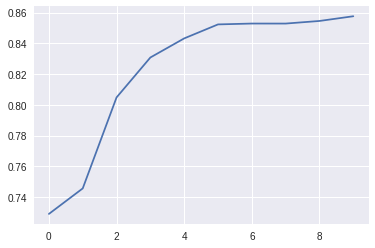

In [24]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [31]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=20)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 547 ms, sys: 7.06 ms, total: 554 ms
Wall time: 326 ms
[0.059062770036296904, 0.1405220030056154, 0.9783950170839537, 0.8695742803774137]


In [32]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=40)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 999 ms, sys: 4.01 ms, total: 1 s
Wall time: 644 ms
[0.05608746695400045, 0.13948045866739653, 0.9805169045752153, 0.8715005372017949]


In [33]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=80)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1.9 s, sys: 14.3 ms, total: 1.91 s
Wall time: 1.08 s
[0.054780511750726305, 0.13812133094514603, 0.9814143191863508, 0.8739925892628081]


# OOB SCORE

In [25]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.057592417165998555, 0.13760237811829082, 0.9794573287062557, 0.8749376866715448, 0.8613697938038829]


- Start with 20-30 trees
- As adding more trees isn't improving the R2 much
- So we do more hyperparameter tuning and at the end of te project increase the tree to even 1000

# Subsampling

In [53]:
set_rf_samples(300)

In [54]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11875127373490586, 0.1482715164933827, 0.9126620774354515, 0.8547921693351554, 0.8527987495121182]


- Subsampling didnt work well because data is smaller. It would be beneficial wer millions of rows are there
- But we see that diff between R2 of training and valid is very low. So we were overfitting earlier
- to turn off resampling use.    reset_rf_samples()

- Always use Subsampling and estimators around 30-40 for figuring out insights

In [30]:
reset_rf_samples()

In [31]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.058059469785404556, 0.1364268241520468, 0.9791227911813437, 0.8770654043202752, 0.8569468287229502]


# Tree Building Parameters

In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=7, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1062221379617009, 0.142577173974198, 0.9301194392989189, 0.8657313621648762, 0.850149530662323]


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility
- Good values of min sample leaf are 1,3,5,7,21

In [45]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0958694815793622, 0.14316891466142165, 0.9430770941643185, 0.8646145341368245, 0.8610247150121086]


- good max_features are 0.5,sqrt,log2

# RF INTERPRETATION

In [9]:
set_plot_sizes(12,14,16)

- Setting the text anf font sizes of the plot

In [10]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [11]:
y_df = pd.DataFrame({"SalePrice":y});

In [12]:
#def split_vals(a,n): return a[:n].copy(), a[n:].copy()

#n_valid = 300  # same as Kaggle's test set size
#n_trn = len(df)-n_valid
#raw_train, raw_valid = split_vals(df_raw, n_trn)
#X_train, X_valid = split_vals(df, n_trn)
#y_train, y_valid = split_vals(y, n_trn)
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(df,y,test_size=0.2,random_state=0)
X_train.shape, y_train.shape, X_valid.shape

((1168, 83), (1168,), (292, 83))

In [13]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

In [14]:
set_rf_samples(300)

In [15]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0798225826751453, 0.14019739789575375, 0.9605381124192525, 0.8701761499093422, 0.8611270332802683]


In [57]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 68 ms, sys: 1.75 ms, total: 69.7 ms
Wall time: 68.9 ms


(12.237064539935908, 0.25594230839425275)

In [27]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 26.3 ms, sys: 47.2 ms, total: 73.4 ms
Wall time: 171 ms


(12.260251614319106, 0.19707985968456795)

- The parallel tree structure is time efficient rather than the above series structure
- parallel_trees takes a random forest model m and some function to call (here, it is get_preds). This calls this function on every tree in parallel.

## Creating the df_valid datframe
- y_valid is ndarray so we create y_valid_df dataframe
- df_valid is dataframe containing the x_valid and y_valid_df columns

In [47]:
""""X_valid.head()"""
# Creating dataframe of the ndarray y_valid

y_valid_df = pd.DataFrame({"SalePrice":y_valid});y_valid_df.head()
""""
df_valid = pd.concat([X_valid,y_valid_df], axis=1)"""
#Creating dataframe valid having same as X_valid and y_valid_df
df_valid = df.sample(frac=0.2,random_state=0)
df_valid.head()

df_valid['SalePrice']=y_df.sample(frac=0.2,random_state=0)

df_valid.head()
X_valid.shape,df_valid.shape,y_valid_df.shape

((292, 83), (292, 84), (292, 1))

In [51]:
X_valid.head()

y_valid_df.isnull().sum()

df_valid.isnull().sum()

df_valid.head()

y_valid_df.head()

- We checked if there is nan value in df_valid and y_valid_df.Then tally the Saleprice column of both datasets

In [52]:
x = df_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

Index(['IR1', 'IR2', 'IR3', 'Reg'], dtype='object')

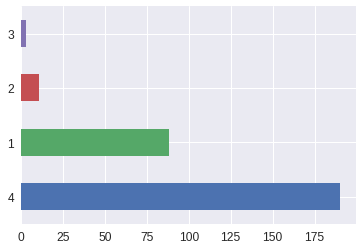

In [73]:
x.LotShape.value_counts().plot.barh();

df_raw.LotShape.cat.categories

- We see that 'Reg' has the most number and 'IR3' has least

In [83]:
x.CentralAir.value_counts().plot.barh()

df_raw.CentralAir.dtype

- We see that There are more number of 'AC' than 'Non Ac'

In [84]:
flds = ['LotShape', 'SalePrice', 'pred', 'pred_std']
Losh_summ = x[flds].groupby('LotShape', as_index=False).mean()
Losh_summ

,LotShape,SalePrice,pred,pred_std
0,1,12.171882,12.157965,0.163020
1,2,12.294675,12.232013,0.158221
2,3,12.122525,12.468840,0.187886
3,4,11.942636,11.944869,0.180278


- We Grouped by LotShape and checked the Deviation between actual and our predicted model
- We can infer from above that our prediction is not very bad

In [99]:
Losh_summ = Losh_summ[~pd.isnull(Losh_summ.SalePrice)]
"""1"""Losh_summ.plot('LotShape', 'SalePrice', 'barh', xlim=(0,15));

"""2"""Losh_summ.plot('LotShape', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,13));

- We use the SD of prediction for our error bars above
- 1st plot is the actual and 2nd plot is the predicted salprice with error
- xlim tells the starting and ending point of the x axis
- alpha is the amount of transparency, greater the alpha lesser will be the transparency

In [111]:
df_valid.Foundation.value_counts().plot.barh()

df_raw.Foundation.cat.categories

flds = ['Foundation', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

In [112]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

Foundation
1    0.018847
4    0.017400
2    0.014721
6    0.014311
3    0.013540
dtype: float64

- We see that 1 and 4 are worst...because most oftenly or genrally having less data implies a less good model. Since,in the histogram 1 and 4 have less data than 2 and 3, they are less accurate.

# Feature Importance

In [16]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
17,OverallQual,0.367183
46,GrLivArea,0.155862
19,YearBuilt,0.050319
61,GarageCars,0.046644
62,GarageArea,0.046052
38,TotalBsmtSF,0.037236
43,1stFlrSF,0.031000
59,GarageYrBlt,0.025108
49,FullBath,0.021072
4,LotArea,0.020515


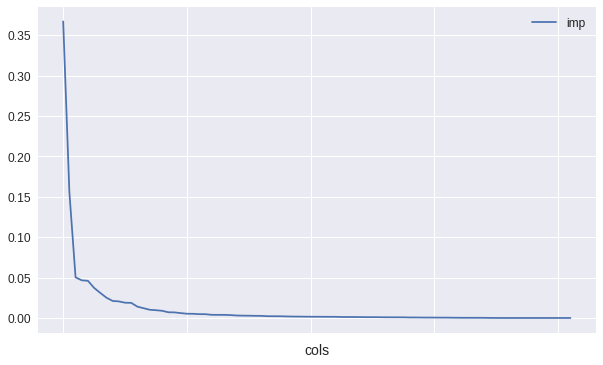

In [17]:
fi.plot('cols', 'imp', figsize=(10,6), legend=True)

In [18]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

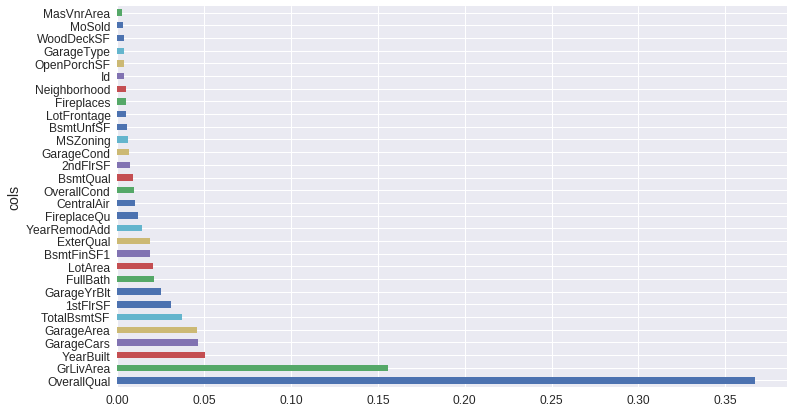

In [19]:
plot_fi(fi[:30]);

In [21]:
to_keep = fi[fi.imp>0.0025].cols;len(to_keep)

33

In [22]:
df_keep = df[to_keep].copy()
# X_train, X_valid = split_vals(df_keep, n_trn)
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(df_keep,y,test_size=0.2,random_state=0)

X_train.shape, y_train.shape, X_valid.shape

((1168, 33), (1168,), (292, 33))

In [23]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

print_score(m)

[0.08208077946420457, 0.13933810302441135, 0.9582737603289586, 0.8717626999301797, 0.8622289399393225]


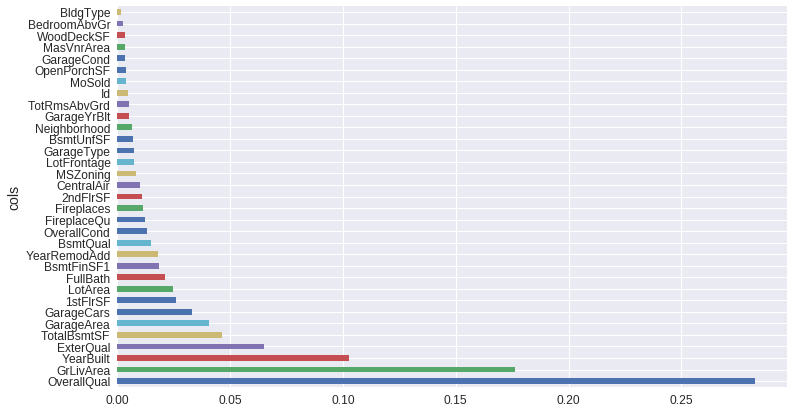

In [24]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# One Hot Encoding

- proc_df function is used to do one hot encoding

In [25]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(df_trn2,y,test_size=0.2,random_state=0)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07872308736947681, 0.13873397682923133, 0.9616177402455375, 0.8728722825129304, 0.8644511349044269]


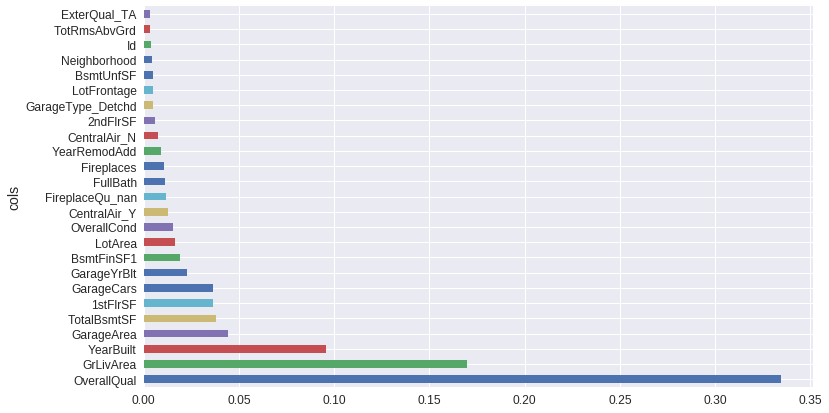

In [26]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing Redundant Features

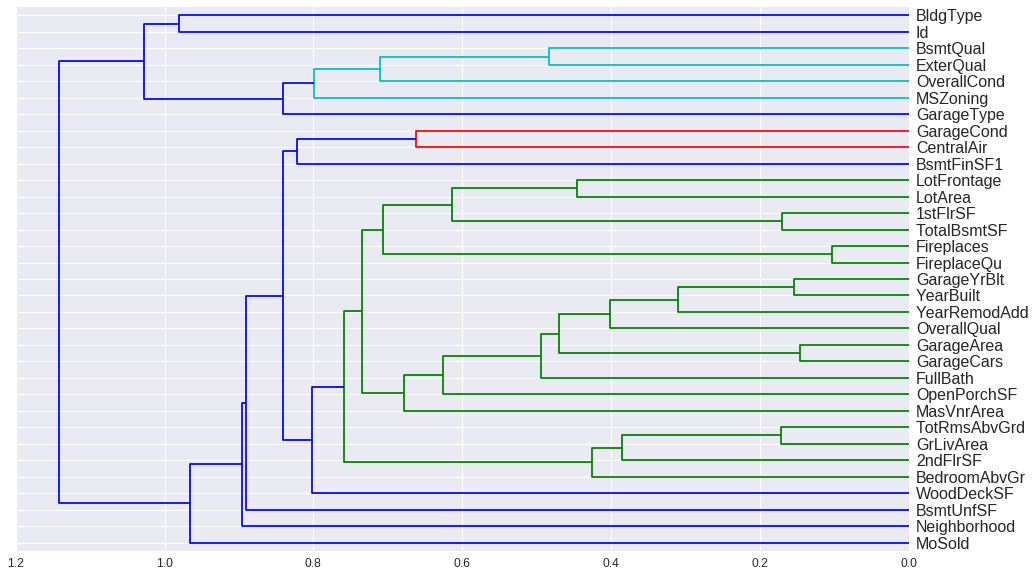

In [28]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

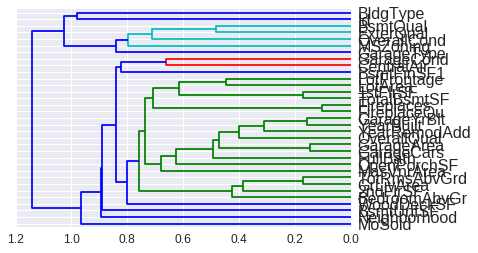

In [29]:
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
      orientation='left', leaf_font_size=16)

- We see that there are no remarkably redundant features

# Partial Dependance

In [33]:
!pip install PDPbox

    100% |████████████████████████████████| 57.7MB 657kB/s 
  Running setup.py bdist_wheel for PDPbox ... done
  Stored in directory: /content/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built PDPbox


In [34]:
from pdpbox import pdp
from plotnine import *

In [35]:
set_rf_samples(300)

In [36]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
#X_train, X_valid = split_vals(df_trn2, n_trn)
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(df_trn2,y_trn,test_size=0.2,random_state=0)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

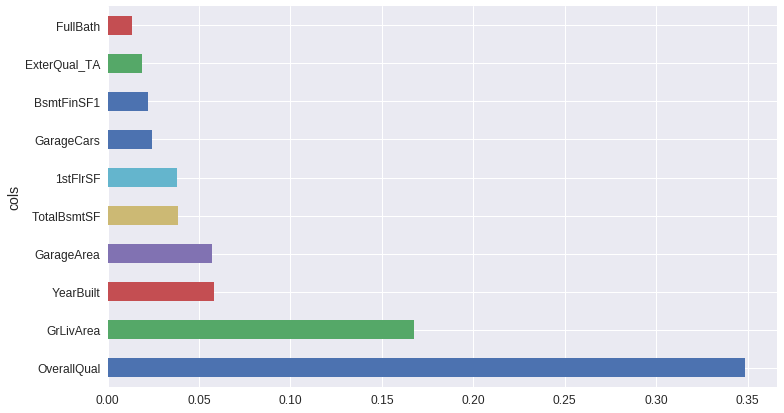

In [37]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

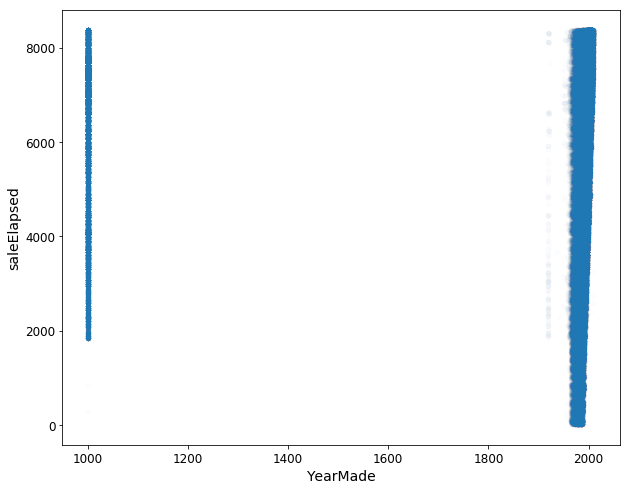

In [48]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));